In [1]:
#pip install -q tensorflow==2.15.0 scikit-image scikit-learn joblib opencv-python-headless

import os, sys, json, random, warnings, itertools, math
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import cv2


In [2]:
# CHANGE THIS to your dataset root. Use a raw string (r"...") on Windows.
ROOT_DIR = r"C:\Users\sajin\OneDrive - Lambton College\neural network\dataset"
ROOT = Path(ROOT_DIR)

if not ROOT.exists():
    raise FileNotFoundError(f"Path not found: {ROOT}")

# List all images in the directory and build labels from folder names
IMG_EXT = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".gif"}
rows = []

for p in ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXT:
        parent = p.parent
        leaf = parent.name
        rows.append({"path": str(p), "leaf": leaf, "parent": str(parent.relative_to(ROOT))})

df = pd.DataFrame(rows)
print("Indexed files:", len(df))

# If a leaf folder name appears in multiple branches, disambiguate with last two parent parts
dups = df.groupby("leaf")["leaf"].transform("size") > 1
df["label"] = df["leaf"]
df.loc[dups, "label"] = df.loc[dups, "parent"].apply(
    lambda s: "_".join(Path(s).parts[-2:]) if len(Path(s).parts)>=2 else Path(s).name
)

# Drop unreadable images from the index (keeps originals untouched)
def is_good(path):
    try:
        with Image.open(path) as im:
            im.verify()
        return True
    except Exception:
        return False

df["ok"] = df["path"].apply(is_good)
df = df[df["ok"]].drop(columns=["ok"]).reset_index(drop=True)

print("Total good images:", len(df))
print("Number of classes:", df["label"].nunique())
df.head()


Indexed files: 192
Total good images: 192
Number of classes: 8


,path,leaf,parent,label
0,C:\Users\sajin\OneDrive - Lambton College\neur...,Atelectasis,Atelectasis,Atelectasis
1,C:\Users\sajin\OneDrive - Lambton College\neur...,Atelectasis,Atelectasis,Atelectasis
2,C:\Users\sajin\OneDrive - Lambton College\neur...,Atelectasis,Atelectasis,Atelectasis
3,C:\Users\sajin\OneDrive - Lambton College\neur...,Atelectasis,Atelectasis,Atelectasis
4,C:\Users\sajin\OneDrive - Lambton College\neur...,Atelectasis,Atelectasis,Atelectasis


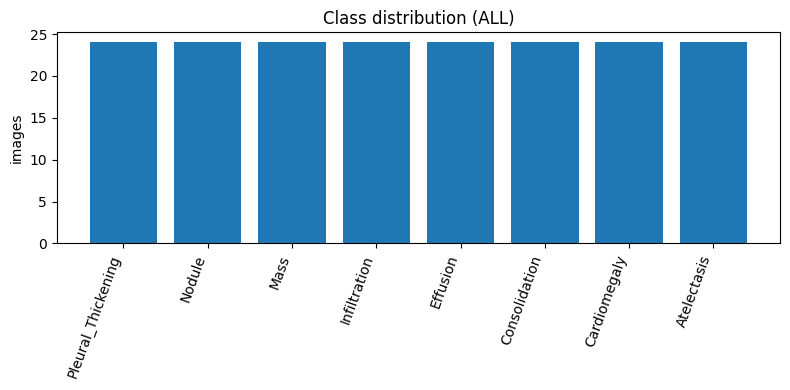

In [4]:
from collections import Counter
def plot_counts(counter, title):
    names = list(counter.keys())
    vals = [counter[k] for k in names]
    idx = np.argsort(vals)[::-1]
    names = [names[i] for i in idx]
    vals  = [vals[i]  for i in idx]

    plt.figure(figsize=(max(8, 0.35*len(names)), 4))
    plt.bar(range(len(names)), vals)
    plt.xticks(range(len(names)), names, rotation=70, ha="right")
    plt.ylabel("images")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_counts(Counter(df['label']), "Class distribution (ALL)")


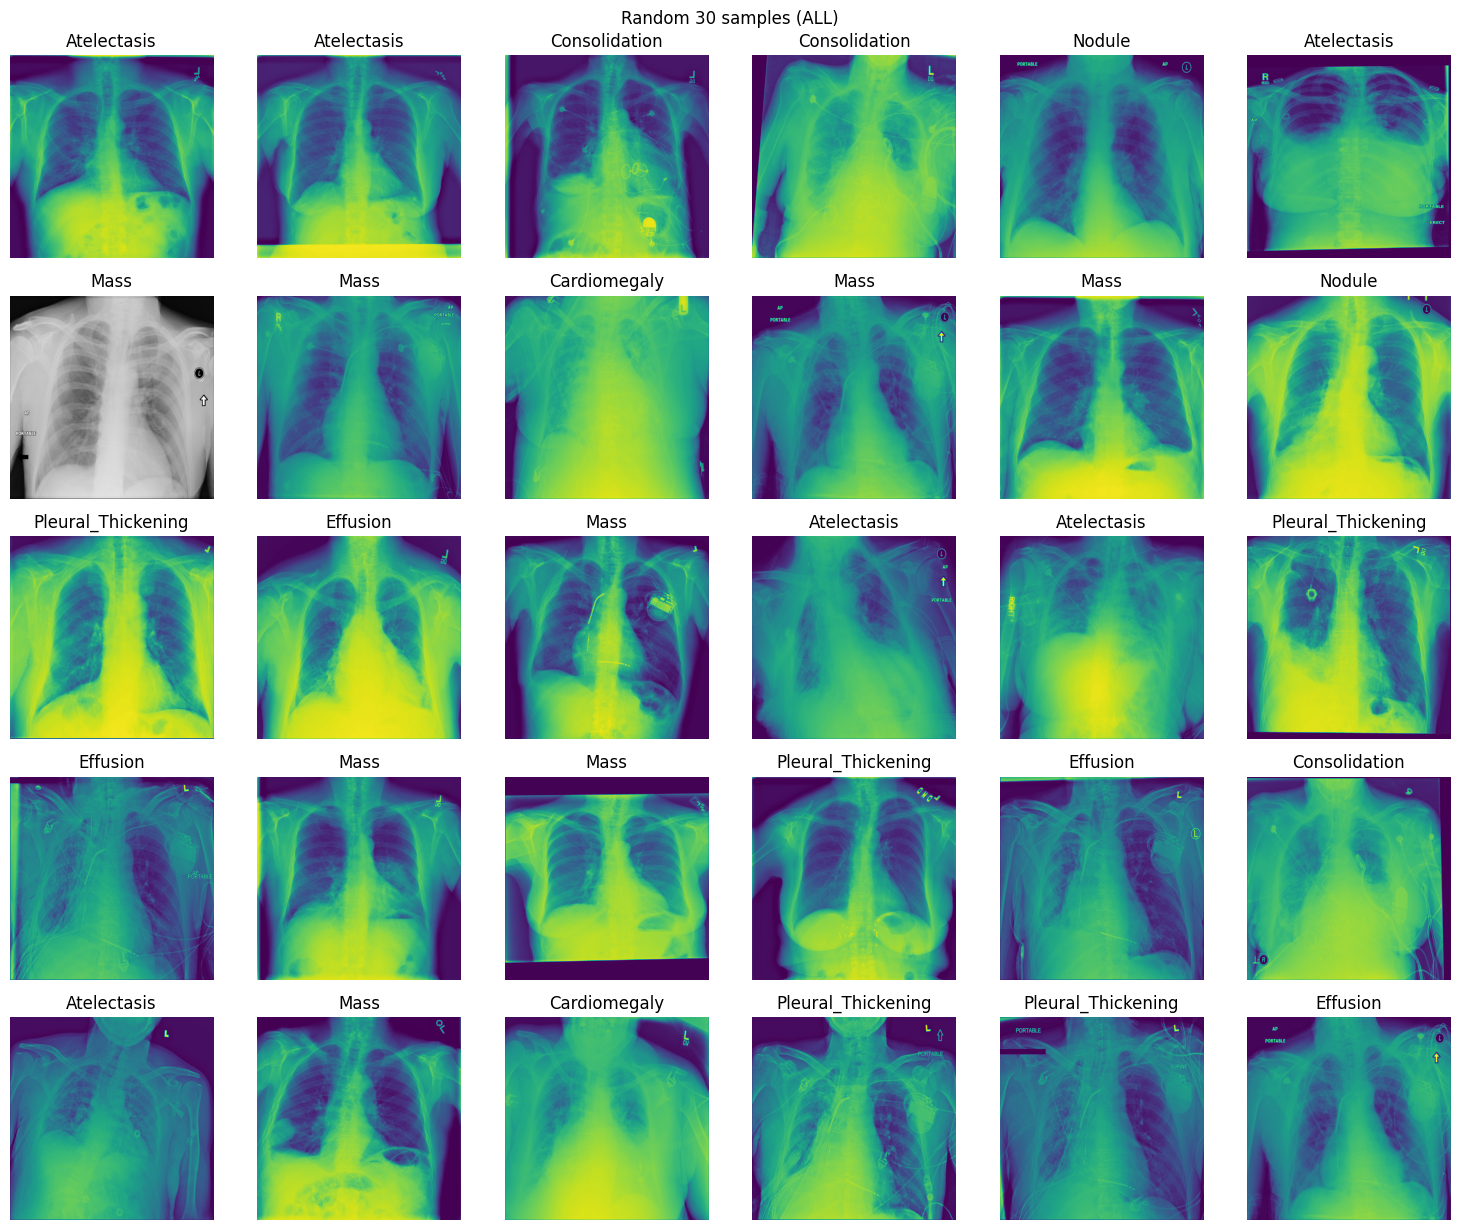

In [5]:
def show_grid(frame, n=30, cols=6, title="Samples"):
    paths = frame["path"].tolist()
    random.shuffle(paths)
    sel = paths[:min(n, len(paths))]
    rows = int(np.ceil(len(sel)/cols))
    plt.figure(figsize=(cols*2.5, rows*2.5))
    for i, p in enumerate(sel):
        ax = plt.subplot(rows, cols, i+1)
        im = Image.open(p)
        plt.imshow(im)
        plt.title(os.path.basename(os.path.dirname(p)))  # class (folder)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_grid(df, n=30, cols=6, title="Random 30 samples (ALL)")


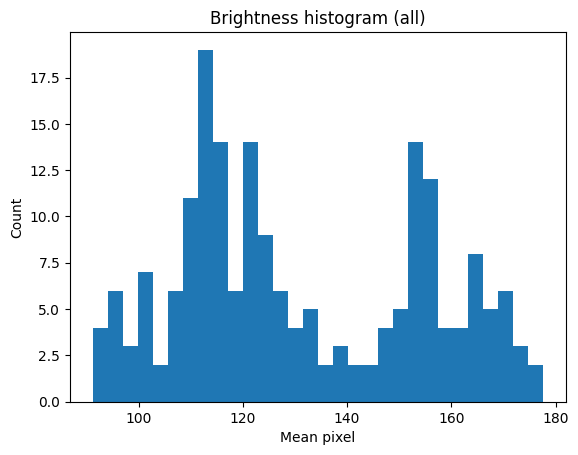

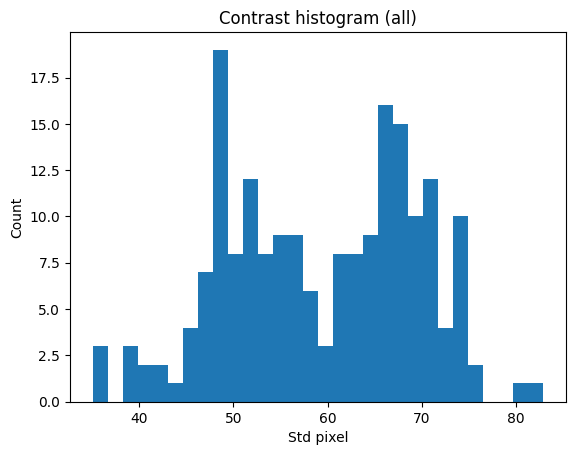

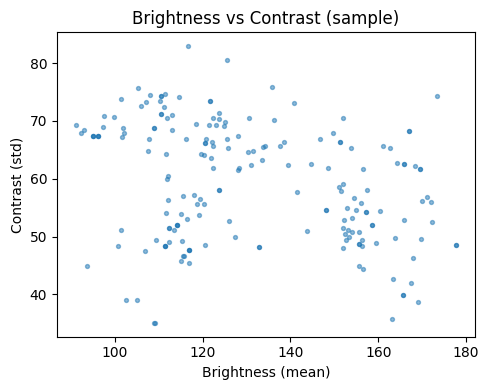

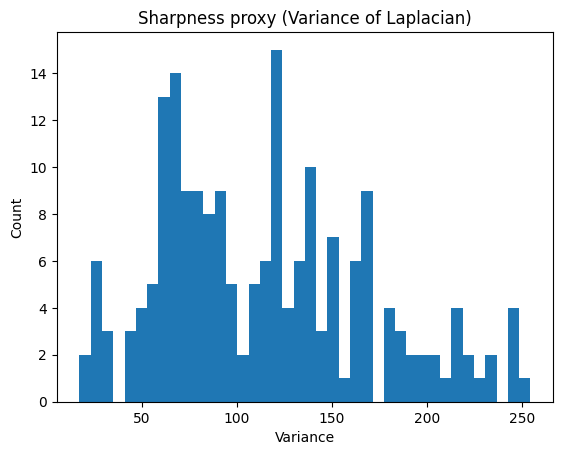

In [6]:
def compute_brightness_contrast(paths, sample=1000):
    bright, contr = [], []
    take = paths if len(paths) <= sample else random.sample(paths, sample)
    for p in take:
        g = Image.open(p).convert("L")
        arr = np.asarray(g, dtype=np.float32)
        bright.append(arr.mean())
        contr.append(arr.std())
    return np.array(bright), np.array(contr)

b_all, c_all = compute_brightness_contrast(df["path"].tolist(), sample=1000)

plt.figure(); plt.hist(b_all, bins=30); plt.title("Brightness histogram (all)"); plt.xlabel("Mean pixel"); plt.ylabel("Count"); plt.show()
plt.figure(); plt.hist(c_all, bins=30); plt.title("Contrast histogram (all)");   plt.xlabel("Std pixel");  plt.ylabel("Count"); plt.show()

# Brightness vs Contrast scatter
plt.figure(figsize=(5,4))
plt.scatter(b_all, c_all, s=8, alpha=0.5)
plt.xlabel("Brightness (mean)"); plt.ylabel("Contrast (std)")
plt.title("Brightness vs Contrast (sample)")
plt.tight_layout(); plt.show()

def laplacian_var(paths, sample=1000):
    vals = []
    take = paths if len(paths) <= sample else random.sample(paths, sample)
    for p in take:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None: 
            continue
        vals.append(cv2.Laplacian(img, cv2.CV_64F).var())
    return np.array(vals)

sharp_vals = laplacian_var(df["path"].tolist(), sample=1000)

plt.figure(); 
plt.hist(sharp_vals, bins=40)
plt.title("Sharpness proxy (Variance of Laplacian)")
plt.xlabel("Variance"); plt.ylabel("Count")
plt.show()


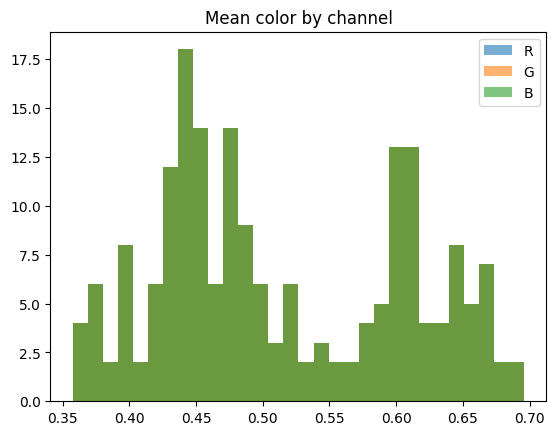

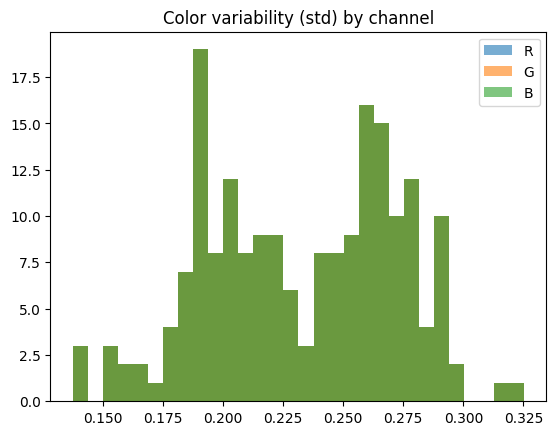

In [7]:
def color_stats(paths, sample=600):
    means, stds = [], []
    take = paths if len(paths) <= sample else random.sample(paths, sample)
    for p in take:
        im = Image.open(p).convert("RGB")
        arr = np.asarray(im, dtype=np.float32)/255.0
        means.append(arr.reshape(-1,3).mean(axis=0))
        stds.append(arr.reshape(-1,3).std(axis=0))
    return np.array(means), np.array(stds)

m, s = color_stats(df["path"].tolist(), sample=600)

plt.figure(); 
plt.hist(m[:,0], bins=30, alpha=0.6, label="R")
plt.hist(m[:,1], bins=30, alpha=0.6, label="G")
plt.hist(m[:,2], bins=30, alpha=0.6, label="B")
plt.title("Mean color by channel"); plt.legend(); plt.show()

plt.figure();
plt.hist(s[:,0], bins=30, alpha=0.6, label="R")
plt.hist(s[:,1], bins=30, alpha=0.6, label="G")
plt.hist(s[:,2], bins=30, alpha=0.6, label="B")
plt.title("Color variability (std) by channel"); plt.legend(); plt.show()


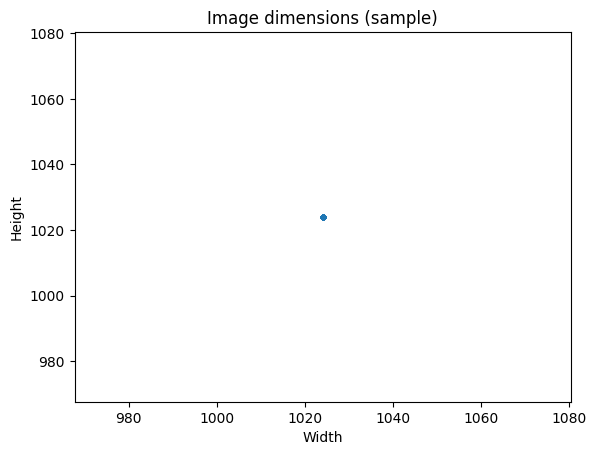

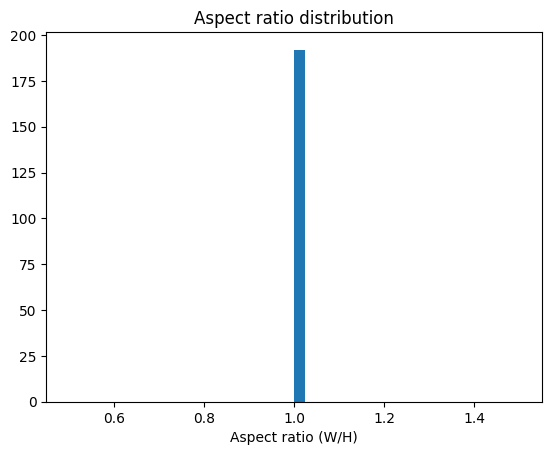

In [8]:
def image_shapes(paths, sample=1200):
    sizes = []
    take = paths if len(paths) <= sample else random.sample(paths, sample)
    for p in take:
        with Image.open(p) as im:
            w, h = im.size
            sizes.append((w,h, w/h if h else 0))
    return np.array(sizes)

sizes = image_shapes(df["path"].tolist(), sample=1200)

plt.figure(); 
plt.scatter(sizes[:,0], sizes[:,1], s=10, alpha=0.4)
plt.xlabel("Width"); plt.ylabel("Height"); plt.title("Image dimensions (sample)")
plt.show()

plt.figure(); 
plt.hist(sizes[:,2], bins=40)
plt.xlabel("Aspect ratio (W/H)"); plt.title("Aspect ratio distribution")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

labels = df["label"].values
paths  = df["path"].values
class_names = sorted(df["label"].unique().tolist())

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=0.30, random_state=42, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=42, stratify=temp_labels
)

def to_frame(paths, labels):
    return pd.DataFrame({"path": paths, "label": labels})

df_train = to_frame(train_paths, train_labels)
df_val   = to_frame(val_paths,   val_labels)
df_test  = to_frame(test_paths,  test_labels)

print("Splits:", df_train.shape, df_val.shape, df_test.shape)


Splits: (134, 2) (29, 2) (29, 2)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = (224, 224)
BATCH = 32
label_to_idx = {c:i for i,c in enumerate(class_names)}
idx_to_label = {i:c for c,i in label_to_idx.items()}

def make_ds(frame, training=False):
    paths = frame["path"].values
    y = frame["label"].map(label_to_idx).values

    ds = tf.data.Dataset.from_tensor_slices((paths, y))

    def _load(path, label):
        img = tf.io.read_file(path)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        label = tf.one_hot(label, depth=len(class_names))
        return img, label

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        aug = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.15),
            layers.RandomContrast(0.1),
        ])
        ds = ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(2048)

    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(df_train, training=True)
val_ds   = make_ds(df_val,   training=False)
test_ds  = make_ds(df_test,  training=False)

print("Datasets ready.")


Datasets ready.


In [11]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base = EfficientNetV2B0(include_top=False, input_shape=IMG_SIZE+(3,), weights="imagenet")
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.35),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

cbs = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=0.5),
    ModelCheckpoint("cnn_v2_best.h5", monitor="val_accuracy", save_best_only=True)
]

hist = model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=2)

# Fine-tune: unfreeze top layers
base.trainable = True
for layer in base.layers[:-25]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=8, verbose=2, callbacks=cbs)

model.save("cnn_v2_final.h5")


Epoch 1/20
5/5 - 22s - 4s/step - accuracy: 0.1493 - loss: 2.2055 - val_accuracy: 0.1724 - val_loss: 2.2042
Epoch 2/20
5/5 - 6s - 1s/step - accuracy: 0.2164 - loss: 2.0269 - val_accuracy: 0.2069 - val_loss: 2.1460
Epoch 3/20
5/5 - 7s - 1s/step - accuracy: 0.1866 - loss: 2.0618 - val_accuracy: 0.2759 - val_loss: 2.0842
Epoch 4/20
5/5 - 6s - 1s/step - accuracy: 0.2164 - loss: 2.0007 - val_accuracy: 0.2759 - val_loss: 2.0753
Epoch 5/20
5/5 - 6s - 1s/step - accuracy: 0.2463 - loss: 1.9699 - val_accuracy: 0.1724 - val_loss: 2.0750
Epoch 6/20
5/5 - 6s - 1s/step - accuracy: 0.2612 - loss: 1.9170 - val_accuracy: 0.1724 - val_loss: 2.0705
Epoch 7/20
5/5 - 6s - 1s/step - accuracy: 0.2761 - loss: 1.8817 - val_accuracy: 0.2069 - val_loss: 2.0825
Epoch 8/20
5/5 - 7s - 1s/step - accuracy: 0.3209 - loss: 1.8299 - val_accuracy: 0.2759 - val_loss: 2.0811
Epoch 9/20
5/5 - 7s - 1s/step - accuracy: 0.3358 - loss: 1.8403 - val_accuracy: 0.2414 - val_loss: 2.1019
Epoch 10/20
5/5 - 6s - 1s/step - accuracy: 0.

5/5 - 24s - 5s/step - accuracy: 0.4179 - loss: 1.6679 - val_accuracy: 0.2414 - val_loss: 2.0348 - learning_rate: 1.0000e-04
Epoch 2/8


5/5 - 8s - 2s/step - accuracy: 0.4478 - loss: 1.6644 - val_accuracy: 0.3448 - val_loss: 2.0506 - learning_rate: 1.0000e-04
Epoch 3/8
5/5 - 9s - 2s/step - accuracy: 0.4701 - loss: 1.6077 - val_accuracy: 0.3448 - val_loss: 2.0557 - learning_rate: 1.0000e-04
Epoch 4/8


5/5 - 20s - 4s/step - accuracy: 0.4552 - loss: 1.6025 - val_accuracy: 0.3793 - val_loss: 2.0626 - learning_rate: 1.0000e-04
Epoch 5/8
5/5 - 11s - 2s/step - accuracy: 0.4925 - loss: 1.5926 - val_accuracy: 0.3793 - val_loss: 2.0611 - learning_rate: 1.0000e-04
Epoch 6/8
5/5 - 9s - 2s/step - accuracy: 0.5522 - loss: 1.5716 - val_accuracy: 0.3103 - val_loss: 2.0553 - learning_rate: 1.0000e-04
Epoch 7/8
5/5 - 7s - 1s/step - accuracy: 0.4925 - loss: 1.5773 - val_accuracy: 0.3448 - val_loss: 2.0600 - learning_rate: 5.0000e-05
Epoch 8/8
5/5 - 7s - 1s/step - accuracy: 0.5000 - loss: 1.5730 - val_accuracy: 0.3793 - val_loss: 2.0541 - learning_rate: 5.0000e-05


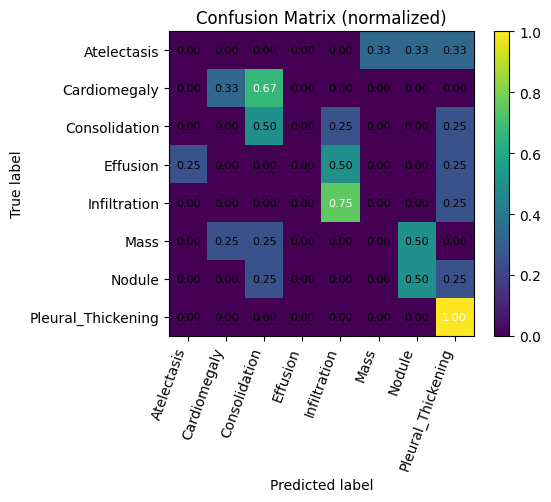

In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predictions
y_true = []
y_prob = []
for xb, yb in test_ds:
    prob = model.predict(xb, verbose=0)
    y_prob.append(prob)
    y_true.append(tf.argmax(yb, axis=1).numpy())

y_true = np.concatenate(y_true)
y_prob = np.concatenate(y_prob)
y_pred = np.argmax(y_prob, axis=1)

cnn_metrics = {
    "accuracy": float(accuracy_score(y_true, y_pred)),
    "f1_macro": float(f1_score(y_true, y_pred, average="macro"))
}

# Confusion matrix (normalized)
def plot_confusion(y_true, y_pred, labels, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(max(6, 0.45*len(labels)), max(5, 0.45*len(labels))))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix" + (" (normalized)" if normalize else ""))
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=70, ha="right")
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i,j]:.2f}" if normalize else str(cm[i,j])
            plt.text(j, i, txt, ha="center", va="center",
                     color="white" if cm[i,j] > thresh else "black", fontsize=8)
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion(y_true, y_pred, class_names, normalize=True)


In [13]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# Step 1: Import required libraries
from skimage.feature import hog
import cv2, joblib
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from PIL import Image

# Step 2: Define the image size for resizing
IMG_SIZE = (128, 128)  # Resize to 128x128 or any smaller size

# Step 3: Define the label-to-index mapping for the dataset
label_to_idx = {label: idx for idx, label in enumerate(df_train["label"].unique())}

# Step 4: Extract HOG features
def extract_hog(paths, labels):
    X, y = [], []
    for p, lab in zip(paths, labels):
        img = Image.open(p).convert("L")  # Convert to grayscale using PIL
        img = np.array(img)  # Convert to numpy array
        img = cv2.resize(img, IMG_SIZE)  # Resize the image to 128x128 to reduce memory
        feat = hog(img, orientations=6, pixels_per_cell=(8, 8),
                   cells_per_block=(1, 1), block_norm="L2-Hys")  # Reduced HOG parameters
        X.append(feat)
        y.append(label_to_idx[lab])  # Convert label to index
    return np.array(X), np.array(y)

# Step 5: Extract HOG features for training, validation, and testing datasets
Xtr, ytr = extract_hog(df_train["path"].values, df_train["label"].values)
Xva, yva = extract_hog(df_val["path"].values, df_val["label"].values)
Xte, yte = extract_hog(df_test["path"].values, df_test["label"].values)

# Step 6: Define classifiers and their hyperparameter grid
svm = Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True, random_state=42))])
rf  = Pipeline([("clf", RandomForestClassifier(random_state=42))])
knn = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier())])

svm_grid = {"clf__C":[0.5,1,5], "clf__kernel":["rbf","linear"], "clf__gamma":["scale","auto"]}
rf_grid  = {"clf__n_estimators":[200,400], "clf__max_depth":[None,20,40]}
knn_grid = {"clf__n_neighbors":[3,5,9], "clf__weights":["uniform","distance"]}

# Step 7: Define GridSearchCV function for hyperparameter tuning
def tune(model, grid, X, y):
    gs = GridSearchCV(model, grid, cv=3, n_jobs=-1, scoring="accuracy")
    gs.fit(X, y)
    return gs.best_estimator_, gs.best_score_, gs.best_params_

# Step 8: Perform GridSearchCV for each model and save the best models
svm_best, svm_cv, svm_params = tune(svm, svm_grid, Xtr, ytr)
rf_best,  rf_cv,  rf_params  = tune(rf,  rf_grid,  Xtr, ytr)
knn_best, knn_cv, knn_params = tune(knn, knn_grid, Xtr, ytr)

# Step 9: Save the best models as .pkl files using joblib
joblib.dump(svm_best, "D:\\GIT\\svm_hog.pkl")
joblib.dump(rf_best,  "D:\\GIT\\rf_hog.pkl")
joblib.dump(knn_best, "D:\\GIT\\knn_hog.pkl")

print("Saved: svm_hog.pkl, rf_hog.pkl, knn_hog.pkl")


Saved: svm_hog.pkl, rf_hog.pkl, knn_hog.pkl


In [20]:
# ---------------------------- MODELS & GRIDS (FIXED) ----------------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

svm = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", SVC(probability=True, random_state=SEED))
])

rf  = Pipeline([
    ("clf", RandomForestClassifier(random_state=SEED))
])

knn = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", KNeighborsClassifier())
])

# ✅ Use <step>__<param> with double underscores
svm_grid = {
    "clf__C": [0.5, 1, 5],
    "clf__kernel": ["rbf", "linear"],
    "clf__gamma": ["scale", "auto"]
}

rf_grid  = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 20, 40]
}

knn_grid = {
    "clf__n_neighbors": [3, 5, 9],
    "clf__weights": ["uniform", "distance"]
}

def check_grid(model, grid):
    params = set(model.get_params().keys())
    bad = [k for k in grid if k not in params]
    if bad:
        raise ValueError(
            f"Invalid grid keys {bad}. "
            f"Valid keys include e.g.: {sorted(list(params))[:25]}"
        )

# Sanity check your grids before running GridSearchCV
check_grid(svm, svm_grid)
check_grid(rf,  rf_grid)
check_grid(knn, knn_grid)


In [21]:
# ===================== SINGLE-CELL: MODEL COMPARISON + PICKLE SAVING (FIXED) =====================
# Trains/tunes SVM, RandomForest, KNN on HOG features; compares on val/test; saves models as .pkl.
# (Optional) also trains EfficientNetB0, saves .keras + a small pickle bundle.

import os, json, time, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import cv2, joblib
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

# ---------------------------- CONFIG ----------------------------
OUT_DIR = "./outputs"
MODELS_DIR = f"{OUT_DIR}/models"
METRICS_DIR = f"{OUT_DIR}/metrics"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
IMG_SIZE_HOG = (128, 128)

ENABLE_EFFICIENTNET = False           # <-- set True to also train/save EfficientNetB0
IMG_SIZE_CNN = (224, 224)
BATCH_SIZE = 32
EPOCHS_TOP, EPOCHS_FT = 5, 5

# ---------------------------- LABELS ----------------------------
class_names = sorted(df_train["label"].unique().tolist())
label_to_idx = {lab: i for i, lab in enumerate(class_names)}
with open(f"{OUT_DIR}/class_names.json", "w", encoding="utf-8") as f:
    json.dump(class_names, f, indent=2)

# ---------------------------- HOG FEATURES ----------------------------
def extract_hog(paths, labels):
    X, y = [], []
    for p, lab in zip(paths, labels):
        # load grayscale safely
        with Image.open(p) as im:
            img = im.convert("L")
            img = np.array(img)
        img = cv2.resize(img, IMG_SIZE_HOG, interpolation=cv2.INTER_AREA)
        feat = hog(
            img,
            orientations=6,
            pixels_per_cell=(8, 8),
            cells_per_block=(1, 1),
            block_norm="L2-Hys",
            feature_vector=True
        )
        X.append(feat.astype(np.float32))
        y.append(label_to_idx[lab])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.int64)

Xtr, ytr = extract_hog(df_train["path"].values, df_train["label"].values)
Xva, yva = extract_hog(df_val["path"].values,   df_val["label"].values)
Xte, yte = extract_hog(df_test["path"].values,  df_test["label"].values)

# ---------------------------- MODELS & GRIDS (FIXED) ----------------------------
svm = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", SVC(probability=True, random_state=SEED))
])
rf  = Pipeline([
    ("clf", RandomForestClassifier(random_state=SEED))
])
knn = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", KNeighborsClassifier())
])

# ✅ Use <step>__<param> keys (double underscore)
svm_grid = {
    "clf__C": [0.5, 1, 5],
    "clf__kernel": ["rbf", "linear"],
    "clf__gamma": ["scale", "auto"]
}
rf_grid  = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 20, 40]
}
knn_grid = {
    "clf__n_neighbors": [3, 5, 9],
    "clf__weights": ["uniform", "distance"]
}

def check_grid(model, grid):
    params = set(model.get_params().keys())
    bad = [k for k in grid if k not in params]
    if bad:
        raise ValueError(
            f"Invalid grid keys {bad}. "
            f"Valid keys include e.g.: {sorted(list(params))[:25]}"
        )

check_grid(svm, svm_grid); check_grid(rf, rf_grid); check_grid(knn, knn_grid)

def tune(model, grid, X, y, cv=3, scoring="accuracy"):
    gs = GridSearchCV(model, grid, cv=cv, n_jobs=-1, scoring=scoring, refit=True, verbose=0)
    gs.fit(X, y)
    return gs.best_estimator_, gs.best_score_, gs.best_params_

# ---------------------------- TRAIN + SELECT ----------------------------
svm_best, svm_cv, svm_params = tune(svm, svm_grid, Xtr, ytr)
rf_best,  rf_cv,  rf_params  = tune(rf,  rf_grid,  Xtr, ytr)
knn_best, knn_cv, knn_params = tune(knn, knn_grid, Xtr, ytr)

# ---------------------------- EVALUATE (VAL/TEST) ----------------------------
def eval_model(name, mdl, X, y, save_prefix=None):
    y_pred = mdl.predict(X)
    acc = accuracy_score(y, y_pred)
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(y, y_pred, average="macro", zero_division=0)
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(y, y_pred, average="weighted", zero_division=0)
    report = classification_report(y, y_pred, target_names=class_names, zero_division=0, output_dict=True)
    cm = confusion_matrix(y, y_pred).tolist()
    if save_prefix:
        with open(f"{METRICS_DIR}/{save_prefix}_report.json", "w", encoding="utf-8") as f:
            json.dump(report, f, indent=2)
        pd.DataFrame(cm).to_csv(f"{METRICS_DIR}/{save_prefix}_confusion_matrix.csv", index=False)
    return {"model": name, "accuracy": acc, "f1_macro": f1_m, "f1_weighted": f1_w}

svm_val = eval_model("svm_hog", svm_best, Xva, yva, save_prefix="svm_hog")
rf_val  = eval_model("rf_hog",  rf_best,  Xva, yva, save_prefix="rf_hog")
knn_val = eval_model("knn_hog", knn_best, Xva, yva, save_prefix="knn_hog")

print("[VAL ACC] SVM: %.4f | RF: %.4f | KNN: %.4f" % (svm_val["accuracy"], rf_val["accuracy"], knn_val["accuracy"]))
print("[TEST ACC] SVM: %.4f | RF: %.4f | KNN: %.4f" % (
    accuracy_score(yte, svm_best.predict(Xte)),
    accuracy_score(yte, rf_best.predict(Xte)),
    accuracy_score(yte, knn_best.predict(Xte)),
))

# ---------------------------- SAVE PICKLES ----------------------------
ts = time.strftime("%Y%m%d-%H%M%S")
svm_path = f"{MODELS_DIR}/svm_hog_{ts}.pkl"
rf_path  = f"{MODELS_DIR}/rf_hog_{ts}.pkl"
knn_path = f"{MODELS_DIR}/knn_hog_{ts}.pkl"
joblib.dump(svm_best, svm_path); joblib.dump(rf_best, rf_path); joblib.dump(knn_best, knn_path)

rows = [
    {**svm_val, "type":"classical", "path_primary": svm_path, "best_params": svm_params, "cv_score": svm_cv},
    {**rf_val,  "type":"classical", "path_primary": rf_path,  "best_params": rf_params,  "cv_score": rf_cv },
    {**knn_val, "type":"classical", "path_primary": knn_path, "best_params": knn_params, "cv_score": knn_cv},
]

# ---------------------------- (OPTIONAL) EfficientNetB0 ----------------------------
if ENABLE_EFFICIENTNET:
    import tensorflow as tf
    from tensorflow.keras import layers

    def make_tf_dataset(df, img_size=IMG_SIZE_CNN, batch=BATCH_SIZE, shuffle=False):
        paths = df["path"].values
        labels = df["label"].map(label_to_idx).astype("int32").values
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        def _load(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_image(img, channels=3, expand_animations=False)
            img = tf.image.resize(img, img_size)
            img = tf.cast(img, tf.float32) / 255.0
            return img, label
        ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
        if shuffle:
            ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
        return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

    train_ds = make_tf_dataset(df_train, shuffle=True)
    val_ds   = make_tf_dataset(df_val,   shuffle=False)

    base = tf.keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(IMG_SIZE_CNN[0], IMG_SIZE_CNN[1], 3)
    )
    base.trainable = False
    inp = layers.Input(shape=(IMG_SIZE_CNN[0], IMG_SIZE_CNN[1], 3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(len(class_names), activation="softmax")(x)
    effnet = tf.keras.Model(inp, out)
    effnet.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                   loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    ckpt_path = f"{MODELS_DIR}/efficientnetb0_best.keras"
    cbs = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", mode="max", save_best_only=True, verbose=0),
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.2, patience=2, verbose=0),
    ]
    effnet.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_TOP, callbacks=cbs, verbose=0)

    # Fine-tune last ~20% layers
    n_layers = len(base.layers)
    for L in base.layers[-max(1, n_layers//5):]:
        L.trainable = True
    effnet.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                   loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    effnet.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FT, callbacks=cbs, verbose=0)

    if os.path.exists(ckpt_path):
        effnet = tf.keras.models.load_model(ckpt_path)

    # Eval on val
    y_true_cnn, y_pred_cnn = [], []
    for imgs, labels in val_ds:
        probs = effnet.predict(imgs, verbose=0)
        y_pred_cnn.extend(np.argmax(probs, axis=1))
        y_true_cnn.extend(labels.numpy())
    y_true_cnn, y_pred_cnn = np.array(y_true_cnn), np.array(y_pred_cnn)

    # metrics save
    rep = classification_report(y_true_cnn, y_pred_cnn, target_names=class_names, zero_division=0, output_dict=True)
    cm = confusion_matrix(y_true_cnn, y_pred_cnn).tolist()
    with open(f"{METRICS_DIR}/efficientnetb0_report.json","w",encoding="utf-8") as f: json.dump(rep,f,indent=2)
    pd.DataFrame(cm).to_csv(f"{METRICS_DIR}/efficientnetb0_confusion_matrix.csv", index=False)

    # save keras + bundle
    ts_eff = time.strftime("%Y%m%d-%H%M%S")
    keras_path = f"{MODELS_DIR}/efficientnetb0_{ts_eff}.keras"
    effnet.save(keras_path)
    bundle = {"type":"keras_bundle","model_path":keras_path,
              "class_names":class_names,"image_size":list(IMG_SIZE_CNN)}
    bundle_path = f"{MODELS_DIR}/efficientnetb0_{ts_eff}_bundle.pkl"
    with open(bundle_path,"wb") as f: pickle.dump(bundle,f,protocol=pickle.HIGHEST_PROTOCOL)

    # add to summary rows
    acc = accuracy_score(y_true_cnn, y_pred_cnn)
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(y_true_cnn, y_pred_cnn, average="macro", zero_division=0)
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(y_true_cnn, y_pred_cnn, average="weighted", zero_division=0)
    rows.append({"model":"efficientnetb0","type":"cnn","accuracy":acc,"f1_macro":f1_m,"f1_weighted":f1_w,
                 "path_primary":keras_path,"path_pickle_bundle":bundle_path})

# ---------------------------- SUMMARY TABLE ----------------------------
summary = pd.DataFrame(rows).sort_values(by="f1_macro", ascending=False)
summary.to_csv(f"{METRICS_DIR}/model_comparison_summary.csv", index=False)
summary.to_json(f"{METRICS_DIR}/model_comparison_summary.json", orient="records", indent=2)

print("=== Model Comparison (Validation) ===")
print(summary)
print("\nSaved classical models:")
print(os.path.basename(svm_path), os.path.basename(rf_path), os.path.basename(knn_path))
if ENABLE_EFFICIENTNET:
    print("Saved EfficientNetB0: .keras + _bundle.pkl")
print("\nPer-model metrics ->", METRICS_DIR)
print("Summary CSV/JSON ->", f"{METRICS_DIR}/model_comparison_summary.*")


[VAL ACC] SVM: 0.2414 | RF: 0.3448 | KNN: 0.2759
[TEST ACC] SVM: 0.2759 | RF: 0.2759 | KNN: 0.2759
=== Model Comparison (Validation) ===
     model  accuracy  f1_macro  f1_weighted       type  \
1   rf_hog  0.344828  0.305556     0.299234  classical   
2  knn_hog  0.275862  0.229482     0.222571  classical   
0  svm_hog  0.241379  0.198133     0.198925  classical   

                                   path_primary  \
1   ./outputs/models/rf_hog_20250814-032036.pkl   
2  ./outputs/models/knn_hog_20250814-032036.pkl   
0  ./outputs/models/svm_hog_20250814-032036.pkl   

                                         best_params  cv_score  
1  {'clf__max_depth': None, 'clf__n_estimators': ...  0.253704  
2  {'clf__n_neighbors': 5, 'clf__weights': 'unifo...  0.231313  
0  {'clf__C': 0.5, 'clf__gamma': 'scale', 'clf__k...  0.253872  

Saved classical models:
svm_hog_20250814-032036.pkl rf_hog_20250814-032036.pkl knn_hog_20250814-032036.pkl

Per-model metrics -> ./outputs/metrics
Summary CSV/JSON 

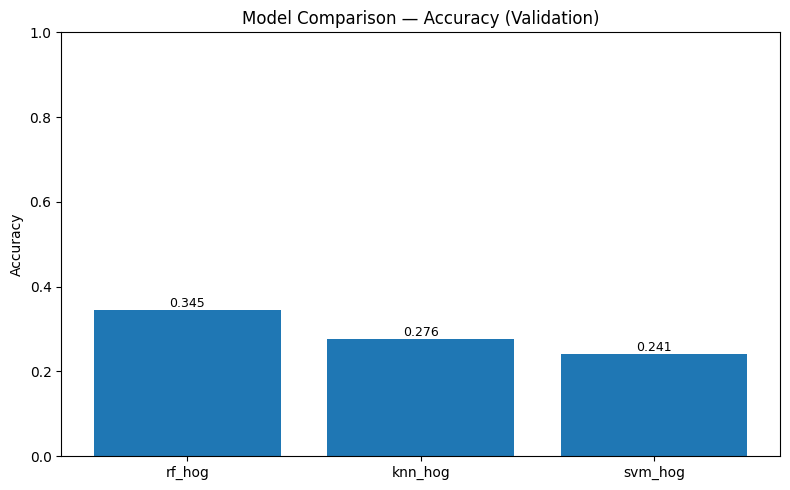

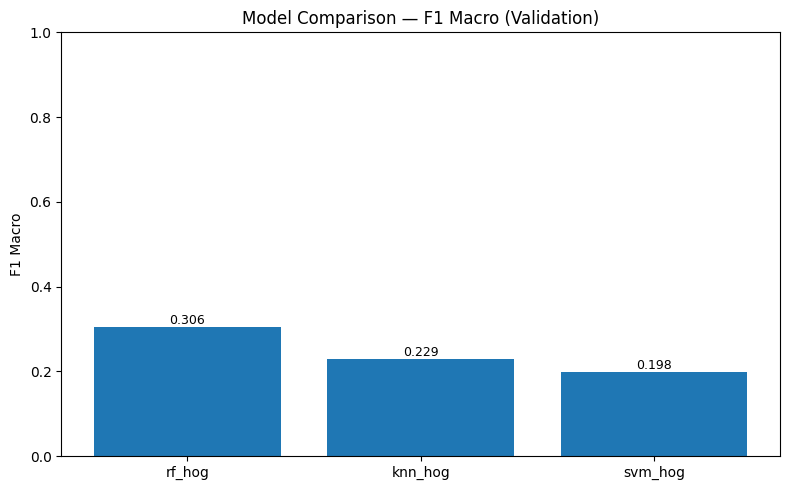

Saved charts:
 - ./outputs/metrics/model_comparison_accuracy.png
 - ./outputs/metrics/model_comparison_f1_macro.png


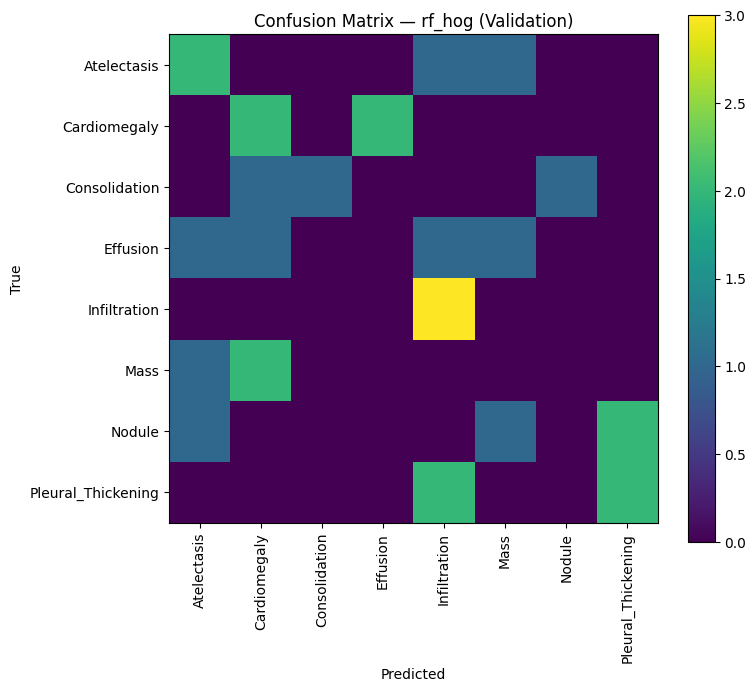

 - ./outputs/metrics\rf_hog_confusion_matrix_plot.png


In [22]:
# ===================== GRAPHS: MODEL COMPARISON + (OPTIONAL) CONFUSION MATRIX =====================
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "./outputs"
METRICS_DIR = f"{OUT_DIR}/metrics"

# 1) Get the comparison table (reuse `summary` if it exists; otherwise load from disk)
try:
    _ = summary  # check it exists
except NameError:
    summary_path = f"{METRICS_DIR}/model_comparison_summary.json"
    summary = pd.read_json(summary_path)

# Ensure consistent ordering (best first by F1 Macro)
summary = summary.sort_values(by="f1_macro", ascending=False).reset_index(drop=True)

# Helper to annotate bars with values
def _annotate_bars(ax, values):
    for idx, v in enumerate(values):
        ax.text(idx, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9, rotation=0)

# 2) Bar chart — Accuracy
plt.figure(figsize=(8, 5))
models = summary["model"].tolist()
accs = summary["accuracy"].astype(float).values
plt.bar(models, accs)
plt.ylabel("Accuracy")
plt.title("Model Comparison — Accuracy (Validation)")
plt.ylim(0, 1.0)
_annotate_bars(plt.gca(), accs)
plt.tight_layout()
acc_png = f"{METRICS_DIR}/model_comparison_accuracy.png"
plt.savefig(acc_png, dpi=150)
plt.show()

# 3) Bar chart — F1 Macro
plt.figure(figsize=(8, 5))
f1m = summary["f1_macro"].astype(float).values
plt.bar(models, f1m)
plt.ylabel("F1 Macro")
plt.title("Model Comparison — F1 Macro (Validation)")
plt.ylim(0, 1.0)
_annotate_bars(plt.gca(), f1m)
plt.tight_layout()
f1_png = f"{METRICS_DIR}/model_comparison_f1_macro.png"
plt.savefig(f1_png, dpi=150)
plt.show()

print("Saved charts:")
print(" -", acc_png)
print(" -", f1_png)

# 4) (Optional) Confusion matrix for the best model on validation set
#     This expects you already saved per-model confusion matrices in METRICS_DIR.
#     We’ll pick row 0 (best by F1 Macro) and try to load its CSV.
best_model_row = summary.iloc[0]
best_model_name = best_model_row["model"]
cm_csv_path = os.path.join(METRICS_DIR, f"{best_model_name}_confusion_matrix.csv")

if os.path.exists(cm_csv_path):
    cm_df = pd.read_csv(cm_csv_path)
    cm = cm_df.values

    # Try to load class names back if present
    class_names_path = os.path.join(OUT_DIR, "class_names.json")
    if os.path.exists(class_names_path):
        with open(class_names_path, "r", encoding="utf-8") as f:
            class_names_loaded = json.load(f)
    else:
        class_names_loaded = [str(i) for i in range(cm.shape[0])]

    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix — {best_model_name} (Validation)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names_loaded))
    plt.xticks(tick_marks, class_names_loaded, rotation=90)
    plt.yticks(tick_marks, class_names_loaded)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    cm_png = os.path.join(METRICS_DIR, f"{best_model_name}_confusion_matrix_plot.png")
    plt.savefig(cm_png, dpi=150, bbox_inches="tight")
    plt.show()
    print(" -", cm_png)
else:
    print(f"(Skipping confusion matrix plot — not found: {cm_csv_path})")
